# **실습10. Attention 기반 seq2seq**  

> 본 스켈레톤 코드 파일은 실습 위주로 다룰 것이므로, attention에 대한 개념 이해는 본책 3권의 '0. basic seq2seq의 한계', '1. 도식으로 Attention의 원리 이해하기' 파트를 활용하도록 하자. 본 실습 스켈레톤 코드 파일에서는 '2. 수식과 핵심 코드로 attention 개념 심화하기'로 넘어가볼 것이다.


## 1. 필요한 함수 Import
실습을 시작하기 전, 실습 10에서 정의한 함수들과 클래스를 import 하자. 아래 Cell 은 그대로 실행하면 된다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, dim_input, dim_recurrent, dim_output):
        """ RNN에 필요한 모든 레이어 초기 설정

        매개변수
        ----------
        dim_input: int
            RNN을 지나가는 데이터의 차원 (C)

        dim_recurrent: int
            RNN에 있는 hidden state의 차원 (D)

        dim_output: int
            RNN의 output의 차원 (K)
        """
        super(RNN, self).__init__()
        self.fc_x2h = nn.Linear(dim_input, dim_recurrent)
        self.fc_h2h = nn.Linear(dim_recurrent, dim_recurrent, bias=False)
        self.fc_h2y = nn.Linear(dim_recurrent, dim_output)
        self.relu = nn.ReLU()


        nn.init.xavier_normal_(self.fc_x2h.weight)
        nn.init.xavier_normal_(self.fc_h2h.weight)
        nn.init.xavier_normal_(self.fc_h2y.weight)

    def forward(self, x, h_t=None):
        """ RNN에 대한 완전한 순방향 패스(full forward pass)를 수행.

        매개변수
        ----------
        x: torch.Tensor, shape=(T, N, C)
            batch의 각 시퀀스에 대한 one-hot 인코딩

        h: Optional[torch.Tensor], shape=(1, N, D)
            초기 hidden dimension state h_0에 대한 옵션 설정
            지정되지 않을 경우 영행렬 할당.

        반환 값
        -------
        Tuple[y, h]
            y: torch.Tensor, shape=(T, N, K)
                각 RNN step에 대한 최종 분류 점수
            h: torch.Tensor, shape=(T, N, D)
                각 RNN step에서 계산된 hidden states (초기 상태 h_0는 제외)
        """
        N = x.shape[1]
        D = self.fc_h2h.weight.shape[0]

        # 최초 hidden state 값이 입력되지 않은 경우, 모든 원소를 0으로 초기화한다.
        if h_t is None:
            h_t = torch.zeros(1, N, D, dtype=torch.float32)


        h = []

        for x_t in x:
            h_t = self.relu(self.fc_x2h(x_t.unsqueeze(0)) + self.fc_h2h(h_t))
            h.append(h_t)

        # 즉, RNN의 모든 hidden state를 하나의 행렬로 묶어서 return할 것이다. (torch.cat 기능 사용할 것)
        # https://pytorch.org/docs/stable/generated/torch.cat.html
        all_h = torch.cat(h, dim=0)

        # all_y는 T개의 예측 점수가 들어 있는 (T, K) 모양의 배열이다.
        # 각 점수들은 T개의 hidden descriptor로부터 각기 산출된다.
        all_y = self.fc_h2y(all_h)
        return all_y, all_h

In [ ]:
def generate_batch(seq_len_min=1, seq_len_max=20, batch_size=10):
    T_1 = np.random.randint(seq_len_min, seq_len_max + 1)
    digits = np.random.randint(0, 10, (T_1, batch_size))
    one_hot_x = np.zeros((T_1 + 1, batch_size, 12), dtype=np.float32)
    one_hot_x[np.arange(T_1).reshape(-1, 1), np.arange(batch_size), digits] = 1
    one_hot_x[-1, :, -1] = 1
    ends = np.full(batch_size, 11).reshape(1, -1)
    y = np.concatenate([digits[::-1], ends], axis=0)
    return one_hot_x, y, digits

In [ ]:
def one_hot_encode_prediction(y_t):
    """
    분류 점수 y_t에 대한 하나의 batch를 입력받으면,
    가장 높은 점수를 가진 클래스에 해당하는 원-핫 인코딩을 반환하는 함수.
    매개변수
    ----------
    y_t: torch.Tensor, shape=(1, N, K)
        seq2seq 디코딩의 한 step으로부터 예측된 분류 점수
    반환 값
    -------
    s_t1: torch.Tensor, shape=(1, N, K), dtype=torch.float32
        y_t에서의 가장 큰 예측 점수에 해당하는 레이블의 one-hot 인코딩.
        float32의 torch 배열.
    Notes
    -----
    N : batch size
    K : 클래스 개수 (i.e. vocabulary의 크기)
    """
    y_t = y_t.detach().cpu().numpy()
    max_values_mask = (y_t == y_t.max(axis=-1, keepdims=True))
    one_hot_encoded = torch.tensor(max_values_mask.astype(np.float32), dtype=torch.float32)
    return one_hot_encoded

In [ ]:
# 입력
y_t = [[[0.1, 0.5, 0.3, 0.1],
        [0.2, 0.1, 0.6, 0.1],
        [0.5, 0.4, 0.1, 0.0]]]

# 중간
max_values_mask = [[[False, True, False, False],
                    [False, False, True, False],
                    [True, False, False, False]]]

# 출력
one_hot_encoded = torch.tensor([[[0.0, 1.0, 0.0, 0.0],
                                 [0.0, 0.0, 1.0, 0.0],
                                 [1.0, 0.0, 0.0, 0.0]]])



## **2. 수식과 핵심 코드로 attention 개념 심화하기**

### **2.1 수식으로 attention score 개념 다지기**

attention 메커니즘의 핵심은 바로 attention score이다. attention score란, 디코딩 과정에서 인코더의 어느 입력 step에 주목할 것인지의 가중치를 점수로 나타낸 값을 말한다. 디코딩 과정이 t개의 step들로 나뉘어 있다고 생각해보자. (한 step마다 하나의 output을 만든다.) 앞서 언급했듯, attention scores는 ‘인코더의 모든 hidden states’와 ‘현재 디코더의 hidden descriptor’ 두 가지를 모두 고려하여 계산된다. 현재 decoder가 t번째 step에 있다면, attention scores(=$e_t$)의 계산에 필요한 재료들은 이하와 같다.


---



**attention score** =  $\begin{equation}
\vec{e}_t = H^e W_\alpha \vec{h}{}^d_t
\end{equation}$  
>(1) $H^e$: 인코더의 모든 hidden descriptor 모음
>D-차원의 모든 T개의 인코더 hidden descriptors 행렬 (T,D)  
$\begin{align}
&\:\begin{matrix}\xleftarrow{\hspace{0.75em}} & D & \xrightarrow{\hspace{0.75em}}\end{matrix} \\
H^e =\;\, &\begin{bmatrix}\leftarrow & \vec{h}{}^e_1 & \rightarrow \\ \leftarrow & \vec{h}{}^e_2 & \rightarrow \\ \vdots & \vdots & \vdots \\ \leftarrow & \vec{h}{}^e_T & \rightarrow\end{bmatrix}\;\;\begin{matrix}\bigg\uparrow \\ T \\ \bigg\downarrow\end{matrix}
\end{align}$  

>(2) $W_a$: 학습 가능한 매개변수인 가중치에 대한 행렬 (D,D)  
>$\begin{align}
&\;\begin{matrix}\xleftarrow{\hspace{2.25em}} & D & \xrightarrow{\hspace{2.25em}}\end{matrix} \\
W_\alpha =\;\, &\begin{bmatrix}\uparrow & \uparrow & \cdots & \uparrow \\ \vec{W}_1 & \vec{W}_2 & \cdots & \vec{W}_D \\ \downarrow & \downarrow & \cdots & \downarrow\end{bmatrix}\;\;\begin{matrix}\big\uparrow \\ D \\ \big\downarrow\end{matrix}
\end{align}$  

>(3) ${h_t}^d$: $t$ step에서의 디코더 hidden descriptor (D-차원)

위 수식을 달리 설명하면, t step에서의 attention scores인 $e_t$는 ‘${h_t}^d$가 확장된 형태’라고도 볼 수 있다. 이때 디코더의 hidden descriptor는 인코더의 모든 descriptors를 검토한 후 학습을 통해 자신과 가장 ‘연관 있는’ 인코더 토큰이 무엇인지 판단한다. 그리고 모델은 학습을  더 많이 진행함에 따라 ${h_t}^d$와 각 인코더 hidden descriptor 간의 관련도를 더 정확하게 파악하게 된다.

### **2.2 디코더 hidden descriptor의 학습 과정 이해하기**

attention score 계산 수식인 $e_t = H^eW_a{h_t}^d$을 기반으로, ${h_t}^d$가 학습을 통해 어떻게 개선되는지 그 과정을 수식과 코드로 구체적으로 알아보자.  
 ① $H^eW_\alpha$에 대한 행렬곱부터 시작해보자. $H^eW_\alpha$의 각 value는 인코더 hidden state와 가중치 벡터 간의 ‘유사성'을 나타내게 된다.  

 $\begin{align}
&\;\begin{matrix}\xleftarrow{\hspace{4.75em}} & D & \xrightarrow{\hspace{4.75em}}\end{matrix} \\
H^eW_\alpha =\;\, &\begin{bmatrix}\vec{h}{}^e_1\cdot\vec{W}_1 & \vec{h}{}^e_1\cdot\vec{W}_2 & \cdots & \vec{h}{}^e_1\cdot\vec{W}_D \\ \vec{h}{}^e_2\cdot\vec{W}_1 & \vec{h}{}^e_2\cdot\vec{W}_2 & \cdots & \vec{h}^e_2\cdot\vec{W}_D \\ \vdots & \vdots & \ddots & \vdots \\ \vec{h}{}^e_T\cdot\vec{W}_1 & \vec{h}{}^e_T\cdot\vec{W}_2 & \cdots & \vec{h}{}^e_T\cdot\vec{W}_D\end{bmatrix}\;\;\begin{matrix}\bigg\uparrow \\ T \\ \bigg\downarrow\end{matrix}
\end{align}$


In [ ]:
# setup
T = 10  # encoder에 들어가는 input sequence의 길이(length)
N = 32  # batch size
D = 18  # dimension of hidden state
encoder_hidden_states = torch.randn(T, N, D)

In [ ]:
## H^eW_a = W_\alpha @ H^e
## 코드로 적용하면?
"""
위의 방법을 통해, 디코더를 호출할 때마다 다시 계산을 반복하는 것이 아니라, 단 한 번만으로 값들을 계산할 수 있게 된다. 각 디코더 단계 동안, 내적을 통해 최종 attention score 벡터를 계산할 수 있다.
"""
W_alpha = nn.Linear(D, D)
precomputed_encoder_score_vectors = W_alpha(encoder_hidden_states)
# (T, N, D) @ (D, D) -> (T, N, D)

In [ ]:
print("precomputed_encoder_score_vectors shape:", precomputed_encoder_score_vectors.shape)

precomputed_encoder_score_vectors shape: torch.Size([10, 32, 18])


② ${h_t}^d$에 유사성 점수 $H^eW_\alpha$를 행렬곱해주면, 디코더 hidden state의 각 구성 요소에 가중치를 반영할 수 있게 된다. 이렇게 세 가지 요소가 모두 곱해진 $H^eW_a{h_t}^d$는 attention score로 기능하게 된다.

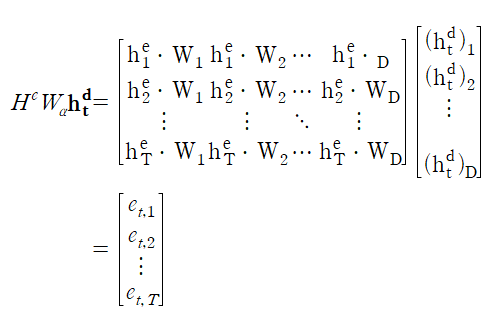

$e_t$ 행렬에서 $i$번째 행은 attention score $e_{t,i}$가 되며, 이때 $e_{t,i}$는 $i$번째 인코더 hidden state와  ${h_t}^d$(=현재 디코더 hidden descriptor)가 서로 관련된 정도 즉 유사도를 표현해주게 된다. 계산 과정을 풀어보자면, 예컨대 $e_{t,1}$을 계산하려면 ${h_1}^e$와 W를 행렬곱한 값에다 D차원의 ${h_t}^d$를 하나씩 곱해줌으로써 구할 수 있다.

In [ ]:
h_t = torch.randn(1, N, D)

### 1. * 사용 뒤 sum (교재에 제시된 방식)

In [ ]:
## e_t = {H^eW_a * {h_t}^d}.sum(axis=-1)
## 코드로 적용하면?
e_t = (precomputed_encoder_score_vectors * h_t).sum(dim=-1)
# (T, N, D) * (1, N, D) -> (T, N, D).sum(axis=-1) -> (T, N)

In [ ]:
print("e_t shape (element-wise multiplication and sum):", e_t.shape)

e_t shape (element-wise multiplication and sum): torch.Size([10, 32])


>잠깐! 3차원 데이터를 다룰 때 데이터의 방향에는 x축 방향, y축 방향, z축 방향이 있다. numpy에서 axis=0는 x축 방향, axis=1는 y축 방향, axis=2은 z축 방향을 가리키며, 3차원 데이터에서 axis=-1는 곧 axis=2 즉 z축 방향을 의미한다. 따라서, 위 수식에서 ‘sum(axis=-1)’란, {*}라는 3차원 데이터에서 z축 방향으로 같은 위치에 놓인 value끼리 합해준다는 것을 의미한다.

### 2. einsum

In [ ]:
## 코드?
e_t_einsum = torch.einsum("TND, ND -> TN", precomputed_encoder_score_vectors, h_t.squeeze(0))
print("e_t shape (einsum):", e_t_einsum.shape)

e_t shape (einsum): torch.Size([10, 32])


In [ ]:
print("h_t shape:", h_t.shape)
print("h_t squeezed shape:", h_t.squeeze(0).shape)

h_t shape: torch.Size([1, 32, 18])
h_t squeezed shape: torch.Size([32, 18])


이 attention scores 벡터를 사용하면, 디코더 hidden descriptor에 대한 attention weights를 계산할 수 있다. 만약 어떠한 인코더 state의 weight가 특히 높다면, "현재 디코더 step의 경우, 다른 hidden states보다 해당 인코더 state에 특히 주목해야 한다"는 정보로 이해할 수 있다. 같은 방식으로, 낮은 가중치값에 대해서는 "현재 디코더 단계의 경우, 이 특정한 인코더 hidden state에 포함된 정보를 대부분 무시해도 된다."라는 의미로 이해하면 된다.

이러한 ① → ②의 방식으로 학습 과정을 반복하면서, 모델은 각 디코더 hidden descriptor에게 각 인코더 hidden state의 중요성을 부여하는 방법을 학습하게 된다. 다시 말해, 모든 인코더 hidden states 가운데 특정 i번째 디코더 hidden state와 가장 ‘관련 있는’ 인코더 hidden state가 무엇인지 더 잘 판단할 수 있도록, i번째 가중치 벡터가 조율된다고 요약할 수 있다. 만약 특정 인코더 hidden state가 어떤 디코더 hidden state(D차원)에 대해 D개의 항 전반에 걸쳐 높은 관련도를 가지고 있다면, 가중치 벡터는 이러한 정보를 학습한 후 attention score을 통해 증폭시킬 것이다. 이렇게 학습을 통해 개선된 가중치 행렬을 통해 모델은 인코더의 hidden descriptors와 디코더의 hidden descriptors 사이의 더 복잡한 문맥적 관계를 파악할 수 있게 된다.



### **2.3 attention weight 계산하기**

실제로 문맥 벡터를 구성하는 값은 attention score가 아니라 attention score를 확률값 형태로 표현한 attention weight이다. 이때 필요한 것은 소프트맥스 함수이다. 우리는 소프트 맥스 함수에 (현재 디코더 hidden descriptor에 대한) attention score을 입력하여, 전체에 대한 확률값(0과 1사이의 값) 형태인 attention weight를 구할 수 있다.

$\alpha_t=softmax(e_t)=\frac{exp(e_t)}{\sum_{i=1}^{T}exp(e_{t,i})}=\frac{exp(e_t)}{exp(e_{t,1})+exp(e_{t,2})+\cdots+exp(e_{t,T})}$  

편리하게도, Pytorch에는 소프트맥스 기능이 내장되어 있다! 단, 소프트맥스를 attention score 행렬에 취할 때, score에 해당되는 축에서 이루어져야 함을 명심하자.  

In [ ]:
## attention weight = softmax(attention score)
## 코드로 적용하면?
a_t = F.softmax(e_t, dim = 0)
# softmax((T, N), axis=0) -> (T, N)

In [ ]:
print("a_t shape:", a_t.shape)

a_t shape: torch.Size([10, 32])


### **2.4 문맥벡터 계산하기**
마지막으로, 우리는 모든 인코더 hidden states의 정보를 '요약'해주는 문맥 벡터 $c_t$를 계산하기 위해 방금 계산한 attention weights를 사용할 것이다. 아래 식에서 알 수 있듯 attention weights $\alpha_j$는 각 인코더 hidden state ${h_j}^e$의 계수가 되며, $\alpha_j$와 ${h_j}^e$에 대한 가중합이 문맥벡터로 기능하게 된다.  

$c_t=\sum_{j=1}^{T}\alpha_j{h_j}^e=\alpha_1({h_1}^e)+\alpha_2({h_2}^e)+\cdots+\alpha_T({h_T}^e)$  

관련성이 상대적으로 적은 인코더 hidden states에는 낮은 attention weights가 주어지게 된다. 따라서, 문맥 벡터는 주로 가장 관련성이 높은 hidden states의 정보를 포함하게 될 것이다. 이를 구현할 때, 1번째 축(N)이 배치 차원 즉 배치 내 시퀀스의 개수를 나타내므로 이에 유의하여 시퀀스 길이를 나타내는 0번째 축(T)을 따라 총합을 계산해야 함을 기억하라.


### 1. * 사용 뒤 sum (교재에 제시된 방식)

In [ ]:
a_t[..., None].shape

torch.Size([10, 32, 1])

In [ ]:
## context vector = {\alpha_j * {h_j}^e}의 가중합
## 코드로 적용하면?
c_t = (a_t[..., None] * encoder_hidden_states).sum(dim=0, keepdim=True)
# (T, N, 1) * (T, N, D) -> (T, N, D).sum(axis=0, keepdims=True) -> (1, N, D)
c_t.shape

torch.Size([1, 32, 18])

### 2. einsum

In [ ]:
## 코드?
c_t_einsum = torch.einsum("TN,TND->ND", a_t, encoder_hidden_states)
c_t_einsum = c_t_einsum.unsqueeze(0)  # (ND) -> (1, N, D)
c_t_einsum.shape

torch.Size([1, 32, 18])

In [ ]:
c_t = torch.einsum("TN,TND->ND", a_t, encoder_hidden_states)
c_t = c_t[None, ...]
c_t.shape

torch.Size([1, 32, 18])

### **2.5 문맥벡터를 디코더에 넘겨주기**

지금까지 문맥벡터 과정을 훌륭하게 이해해보았다. 이제는 문맥 벡터를 어떻게 다루어야 할지 고민해야 한다. 어떤 방식을 통해 디코더에 문맥 벡터와 디코더의 output을 둘 다 입력해줄 수 있을까? 기계학습 연구원들이 해온 방식에 여러 가지가 있는데, 그 중 우리가 취해볼 접근법은, 문맥 벡터 $c_t$를 일반적인 디코더 단계의 output $y_t$과 연결하는(concatenate) 방식이다. 즉, 우리는 디코더 단계에 대한 계산을 $s_t$와 ${h_t}^d$를 사용하여 평소대로 진행하고 $y_t$와 ${h_t}^d$를 얻어낼 것이다. 우리는 $y_t$ 값을 저장한 후, 다음 디코더의 input $s_{t+1}$에는 $y_t$와 문맥 벡터 $c_t$를 이어 붙인 값을 넣어줄 것이다.


In [ ]:
## 문맥벡터를 디코더에 넘겨주기 = 문맥벡터와 디코더 output을 연결
## 코드로 적용하면?

K = 12  # dim_output in decoder (RNN)
y_t = torch.randn(1, N, K)

# 문맥 벡터와 디코더 output을 연결
y_and_c = torch.cat([y_t, c_t], dim=-1)  # (1, N, K), (1, N, D) -> (1, N, K+D)
print("y_and_c shape:", y_and_c.shape)

y_and_c shape: torch.Size([1, 32, 30])


우리는 output 벡터의 차원을 변경하기 때문에, dense layer를 사용하여 output 차원을 수정하고 최종 분류 점수를 재계산해야 한다.

In [ ]:
## 코드?
post_concat_dense = nn.Linear(K + D, K)
y_t = post_concat_dense(y_and_c)
print("y_t shape:", y_t.shape)

y_t shape: torch.Size([1, 32, 12])


이게 전부이다! 마지막 dense layer는 일종의 인터프리터 역할을 하는데, 문맥 벡터에서 전달되는 정보와 디코더 output의 정보를 통합해준다. 따라서 각 디코더 단계에 대한 최종 ouput에는 가장 중요한 인코더 hidden states로부터 직접 가져온 정보가 포함된다.

## **3. 코드로 seq2seq with attention 구현하기** (HW)

이제는, 이 모든 것들을 실행에 옮겨보자. 다행히 이전에 만들어두었던 RNN 클래스를 활용하면, 우리가 현재 필요로하는 텐서, 즉 모든 hidden states를 포함하는 텐서를 반환할 수 있다. 덕분에 우리는 $W_\alpha$에 대한 Linear  <dense>만 잘 정의해주면, attention scores를 계산할 수 있게 되었다. 이때 $H^eW_a$에 대한 계산은, 인코더의 output을 받은 직후, 어떤 다른 decoder 단계가 진행되기 전에 이루어져야 함을 명심하자.

아래 클래스에서 위에서 설명한 attention mechanism을 적용하여 이전의 seq2seq 모델을 강화해보자. 각 디코더 단계에서는 계산된 attention weights를 저장하라. __call__에서는 예측 점수 및 attention weights에 대한 행렬(T,T,N) 을 모두(두 개) 반환하라.

- 이때 (T,T,N)은 데이터를 이루는 시퀀스의 개수이며, 앞의 T,T는 데이터에 대한 길이를 의미한다. 차원이 2번 필요한 것은 각 토큰(T)별로 어떤 토큰(T)이 연관이 많은지 따져야 하기 때문이다. 구체적으로 보면 에서 첫 번째 T는 각 디코더 토큰이 인코더의 어떤 토큰과 관련 있는지(=attention weights)를 나타내주고, 두 번째 T는 디코더 토큰의 개수를 나타낸다. 둘의 의미를 혼동하지 않도록 하자.

In [ ]:
class Attentionseq2seq(nn.Module):
    def __init__(self, dim_input, dim_recurrent, dim_output):
        super(Attentionseq2seq, self).__init__()
        """ Initializes all RNN layers needed for seq2seq

        매개변수
        ----------
        dim_input: int
            RNN을 지나가는 데이터의 차원 (C)

        dim_recurrent: int
            RNN에 있는 hidden state의 차원 (D)

        dim_output: int
            RNN의 output의 차원 (K)


        Notes
        -----
        이 특정 문제에 대해, input의 차원과 output의 차원은 동일(C = K).
        그러나 이것이 일반적인 경우는 아님.
        """
        # (이전에 했던 것처럼) 두 개의 RNNs - 인코더와 디코더 -를 생성(인스턴스화)
        self.encoder = RNN(dim_input, dim_recurrent, dim_output)
        self.decoder = RNN(dim_input, dim_recurrent, dim_output)

        # 이후, 두 개의 dense layer 생성:
        # - 하나는 (D, D) 행렬 W_alpha에 해당되는 것 (bias는 없음),
        # - 하나는 y_t 벡터와 c_t 벡터가 concat된 것 (dim K+D)
        #   적절한 output dimension (dim K)을 갖춘 벡터.
        # 두 개의 dense layers 모두, glorot_normal weight initializer 사용
        self.W_alpha = nn.Linear(dim_recurrent, dim_recurrent, bias=False)
        self.post_concat_dense = nn.Linear(dim_recurrent + dim_output, dim_output)

        nn.init.xavier_normal_(self.W_alpha.weight)
        nn.init.xavier_normal_(self.post_concat_dense.weight)

    def forward(self, x):
        """ seq2seq에 대한 완전한 순방향 패스(full forward pass)를 수행.

        매개변수
        ----------
        x: Union[numpy.ndarray, torch.Tensor], shape=(T, N, C)
            batch에 있는 각 시퀀스에 대한 원-핫 인코딩

        반환 값
        -------
        y: torch.Tensor, shape=(T, N, K)
            각 디코더 step의 output으로부터 산출된 최종 분류 점수
        a_ij: torch.Tensor, shape=(T, T, N)
            sequences의 batch에 대한 attention weights. The 0-th
            0차원은 각 디코더 step에서 계산된 attention weights에 상응함
        """
        # (1) 인코딩 및 디코더 setup을 `seq2seq` 모델에서와 동일하게 수행:
        # - 인코더 hidden states `enc_h`를 받음,
        # - 첫 번째 디코더 hidden state가 마지막 인코더 hidden state가 되도록 설정
        # - 리스트 `y`를 생성하여 디코더 outputs를 저장
        # - <START> 토큰 원-핫 인코딩을 첫 번째 디코더 input으로 초기설정
        T, N, C = x.shape
        _, enc_h = self.encoder(x)
        h_t = enc_h[-1:]
        y = []
        s_t = torch.zeros((1, N, C), dtype=torch.float32)
        s_t[..., -2] = 1

        # (2) W_alpha에 상응하는 dense layer를 `enc_h`에 적용하여
        # attention scores의 일부를 미리 계산
        precomputed_encoder_score_vectors = self.W_alpha(enc_h)

        # (3) 아래 코드는 `a_ij` 리스트를 생성
        # 리스트에 각 디코더 step에서의 attention weights를 저장
        a_ij = []

        for _ in range(T):
            # (4) `e_t`: 현재 디코더 hidden state에 대한 attention scores 계산
            # 사용 수식: 미리 계산된 W_alpha * H^e.
            e_t = (precomputed_encoder_score_vectors * h_t).sum(dim=-1)

            # (5) attention weights: attention scores에 소프트맥스 함수를 취한 것
            # `T` 차원에 대해 softmax 함수를 취할 것을 명심하라.
            # 결과를 변수 `a_t`에 저장.
            a_t = F.softmax(e_t, dim=0)

            # (6) 아래 코드는 현재 디코더 step에 대한 attention weights를 `a_ij` 리스트에 더해줌
            # 새로운 축은 weights가 하나의 행렬로 연결(concatenate)될 수 있도록 만듦
            a_ij.append(a_t.unsqueeze(0)) # unsqueeze는 차원 추가의 의미

            # (7) 인코더 hidden states로부터 문맥 벡터 `c_t`를 계산하라
            # `enc_h` & the attention weights `a_t`.
            c_t = (a_t[..., None] * enc_h).sum(dim=0, keepdim=True)

            # (8) basic seq2seq 모델에서처럼,
            # 하나의 디코더 step를 수행하여 y_t와 h_t를 입력받아라
            y_t, h_t = self.decoder(s_t, h_t)

            # (9) 마지막 축을 따라 디코더 output y_t와 문맥벡터 c_t를 연결(concatenate)하라
            # (1, N, K)와 (1, N, D)를 연결한 결과 (1, N, K+D)의 shape를 가짐
            y_and_c = torch.cat([y_t, c_t], dim=-1)

            # (10) dense layer를 활용하여
            # 연결한(concatenated) 벡터를 -> 적절한 output 차원(K)의 벡터로 압축시켜라
            # 리스트 `y`에 마지막 `y_t`를 추가하라
            y_t = self.post_concat_dense(y_and_c)
            y.append(y_t)

            # (11) `one_hot_encode_prediction`를 사용하여
            # 디코더 output과 문맥벡터 `y_t`의 결합물을 기반으로
            # 다음 디코더 input s_{t+1}을 찾아내라
            s_t = one_hot_encode_prediction(y_t)

        # (12) 0-th axis을 따라
        # `y`에 저장된 y_t 텐서들을 모두 연결(concatenate)하라
        y = torch.cat(y, dim=0)  # y: shape-(T, N, K)

        # (13) 아래 코드를 통해
        # 각 디코더 step에 대해 계산된 T개의 attention vectors `a_t`를 연결할 수 있다
        a_ij = torch.cat(a_ij, dim=0) # a_ij: shape-(T, T, N)

        # (14) 위 docstring에 부합하는 적절한 텐서들과 배열들을 반환하라
        return y, a_ij



Attentionseq2seq 모델과 Adam 옵티마이저를 정의하라. 모델의 경우 dim_recurrent가 25인 것이 좋다. 옵티마이저의 경우 매개변수를 default로 지정하는 것이 시작하는 단계에서 적합할 것이다.

### HW
dim_input과 dim_output은 얼마가 되어야 할까? dim_recurrent처럼 아무 값이나 설정할 수 있는 건 아니다.

In [ ]:
# 여기에 코드 작성 (HW)
model = Attentionseq2seq(dim_input=12, dim_recurrent=25, dim_output=12)
optimizer = optim.Adam(model.parameters())

아래에 학습 loop를 작성하라. 필요에 따라 inputs를 softmax_crossentropy로 reshape해야 함을 기억하라. 이때 배치 크기는 100으로 지정하고, 시퀀스 길이는 1에서 20 사이가 되도록 하라. 모델을 30000회 반복하여 학습시켜라.

In [ ]:
from IPython.display import clear_output
def plot_all(losses, acces):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.plot(acces, label='acc')
    plt.xlabel('Batches (It must multiple x 1000)')
    plt.ylabel('Loss and Acc')
    plt.title('Loss and Acc Averages over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

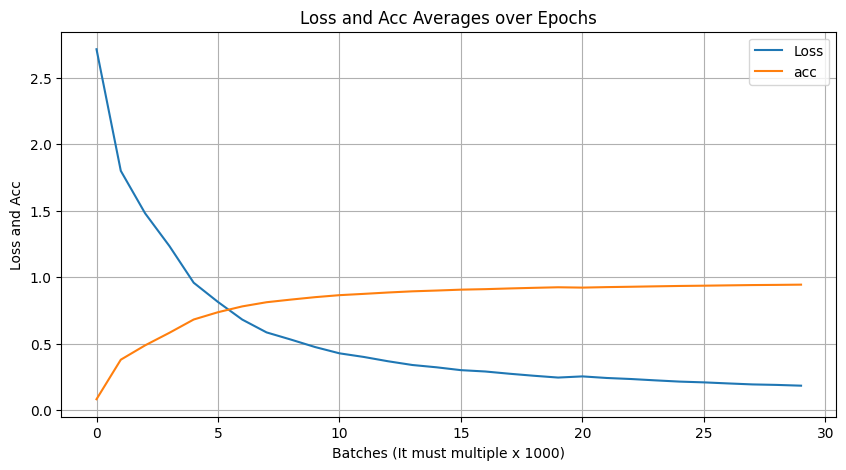

loss: 0.18459738004790202, accuracy: 0.9443335305637143


In [ ]:
# 여기에 코드 작성
batch_size = 100
num_batches = 30000

loss_ = []
acc_ = []
loss_average_list = []
acc_list_average = []
for k in range(num_batches):
    x, target, sequence = generate_batch(batch_size=batch_size)

    x_tensor = torch.tensor(x, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)

    optimizer.zero_grad()
    output, _ = model(x_tensor)

    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(output.reshape(-1, 12), target_tensor.reshape(-1))
    loss.backward()
    optimizer.step()

    acc = (output.argmax(dim=-1) == target_tensor).float().mean().item()

    loss_.append(loss.item())
    acc_.append(acc)
    if k % 1000 == 0:
        acc_average = np.mean(acc_)
        loss_average = np.mean(loss_)
        loss_average_list.append(loss_average)
        acc_list_average.append(acc_average)
        plot_all(loss_average_list, acc_list_average)
        print(f"loss: {loss_average}, accuracy: {acc_average}")

다음을 실행하여 모형의 정확성을 평가하라.

  0%|          | 0/50000 [00:00<?, ?it/s]

i = 0
i = 5000
i = 10000
i = 15000
i = 20000
i = 25000
i = 30000
i = 35000
i = 40000
i = 45000


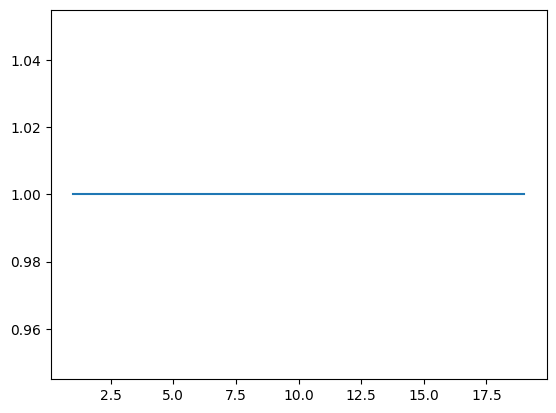

In [ ]:
length_total = defaultdict(int)
length_correct = defaultdict(int)

with torch.no_grad():
    for i in tqdm(range(50000)):
        if i % 5000 == 0:
            print(f"i = {i}")
        x, target, sequence = generate_batch(1, 20, 1)

        x_tensor = torch.tensor(x, dtype=torch.float32)
        target_tensor = torch.tensor(target, dtype=torch.long)

        output, _ = model(x_tensor)

        length_total[sequence.size] += 1
        if (output.argmax(dim=-1) == target_tensor).all():
            length_correct[sequence.size] += 1

fig, ax = plt.subplots()
x, y = [], []
for i in range(1, 20):
    x.append(i)
    y.append(length_correct[i] / length_total[i])
ax.plot(x, y)

이제 우리는 학습한 모든 시퀀스 길이에 대해 거의 완벽에 가까운 정확성을 확인할 수 있다. (충분히 오래 학습한 경우, 모델은 이 문제를 완전히 마스터할 수 있다).

마무리 단계로, 단일 sequence에 대해 계산된 attention weights를 살펴보자. 아래 셀을 실행하면, 선택한 시퀀스 길이에 대한 attention weights를 시각화할 수 있다.

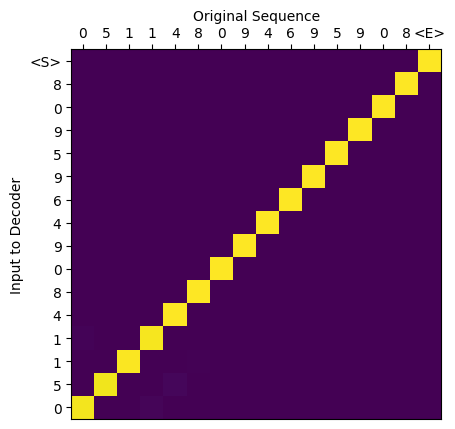

In [ ]:
seq_len = 15

x, target, sequence = generate_batch(seq_len, seq_len, 1)
x_tensor = torch.tensor(x, dtype=torch.float32)
y, a_ij = model(x_tensor)
y = y.argmax(dim=-1).squeeze().cpu().numpy()

fig, ax = plt.subplots()

ax.set_yticks(range(y.size))
ax.set_yticklabels(["<S>"] + [x for x in y[:-1]])
ax.set_ylabel("Input to Decoder")

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.set_xticks(range(target.size))
ax.set_xticklabels([x for x in sequence.squeeze()] + ["<E>"])
ax.set_xlabel("Original Sequence")

ax.imshow(a_ij.squeeze().detach().cpu().numpy())

이런 결과가 나올 것이라 예상하였는가? 우리가 해결하려는 문제를 고려할 때, 직관적으로 이해가 잘 되는가?

사실상 딥러닝 분야에서 attention의 도입됨으로써 딥러닝을 이해하는 데 중요한 진전을 이루어낼 수 있었다. 실제로 attention은 매우 강력한 도구이기 때문에, 마지막 노트에서는 어떻게 우리가 attention만을 활용하여 언어 모델을 구성할 수 있는지 알아보도록 하자.  